In [38]:
import numpy as np
from numpy.linalg import inv
import scipy.linalg as sp
from scipy.linalg import eigh
import matplotlib.pyplot as plt
from math import ceil
import pandas as pd
from scipy.ndimage import gaussian_filter1d
from scipy.integrate import trapz
import h5py
from scipy.optimize import curve_fit
import ana_cont.continuation as cont
import contextlib
import io
import sys

sys.path.insert(0, "/./")
from ipynb.fs.full.DMFT_tools import Hamiltonian, get_Bandstructure
from ipynb.fs.full.DMFT_tools import w2dyn, plot_object, S_iw_adjust, cut_matsubara
from ipynb.fs.full.DMFT_tools import real_to_bloch, get_Hk
%matplotlib inline
plt.rcParams['font.size'] = 20
plt.rcParams['axes.linewidth'] = 2

In [39]:
#### Names for plots
prefix = "NiO_"
postfix = "_0_GPa.png"
#### since it's the longest part, avoids re-doing continuation once it's done
do_analytic_continuation = True
#### calculation parameters
Efermi_dft = 14.9261
w_max = 25
num_iter = 1
num_ineq = 1
num_wann = 5
num_spins = 2
beta = 10.0
#### ana_cont parameters
use_preblur = False
w_grid_type = "lin"   ## "tan" or "lin"
bw = 0.01   ## Preblur width: max same width as the physical peaks
aerr_s = 0.50
alpha_det_method ="chi2kink"
#### cutoff freqs parameters
nKeep = 50       ## Number of Matsubara freqs. kept
nStep = 1         ## every nStep-th element is taken from 0 to nKeep
n_w = 1001        ## Number of real frequencies

In [40]:
H = Hamiltonian(3)
DMFT_results = w2dyn(_num_iter = num_iter, beta = beta, _num_ineq = num_ineq)
DMFT_results.get_results("./NiO_DMFT_U_8_beta_10.hdf5")
H.read_w90_hamiltonian_hr("./NiO_hr.dat")
dos_dft = np.genfromtxt('../DOS/NiO.dos' )

In [41]:
iw_src = DMFT_results.iw[:]
## Using dictionaries because the number of orbitals between different atoms may differ
S_iw_m_s_a_src = {}
S_iw_m_a_full_src = {}
S_iw_m_a_src = {}
S_iw_err_m_a_src = {}
smom_m_a = {}
dc_a = {}
hartree = {}

#print(DMFT_results.smom_m_s[0])
#print(DMFT_results.smom_m_s[1])
for ineq in range(0, num_ineq): ## Loop over inequivalent atoms
    smom_m_a[ineq] = DMFT_results.smom_m[ineq]
    hartree[ineq] = smom_m_a[ineq][:,0]
    dc_a[ineq] = np.mean(DMFT_results.dc[ineq], axis=1)
    S_iw_m_s_a_src[ineq] = DMFT_results.S_iw_m_s[ineq]
    S_iw_m_a_src[ineq] = np.diagonal(np.mean(np.diagonal(S_iw_m_s_a_src[ineq], axis1=1, axis2=3), axis=3), axis1=0, axis2=1).copy()
    S_iw_m_a_full_src[ineq] = np.mean(np.diagonal(S_iw_m_s_a_src[ineq], axis1=1, axis2=3), axis=3) - (hartree[ineq]*np.eye(hartree[ineq].shape[0]))[:,:,np.newaxis]
    S_iw_err_m_a_src[ineq] = np.diagonal(np.mean(np.diagonal(DMFT_results.S_iw_m_s_err[ineq], axis1=1, axis2=3).copy(), axis=3), axis1=0, axis2=1).copy()
    for i in range(0, S_iw_m_a_src[ineq].shape[1]): ## Loop over orbitals
        Re = S_iw_m_a_src[ineq][:,i].real - hartree[ineq][i] #+ np.mean(dc_a[ineq][:])
        Im = S_iw_m_a_src[ineq][:,i].imag
        S_iw_m_a_src[ineq][:,i] = Re + 1.j*Im

In [42]:
check_offdiagonal = False
if check_offdiagonal:
    fig, axs = plt.subplots(5, 5, figsize=(16,16), sharex=True, sharey=True)
    ineq = 1
    for i in range(0, 5):
        for j in range(0, 5):
            axs[i][j].plot(iw_src, S_iw_m_a_full_src[ineq][i][j].real)
            axs[i][j].plot(iw_src, S_iw_m_a_full_src[ineq][i][j].imag)

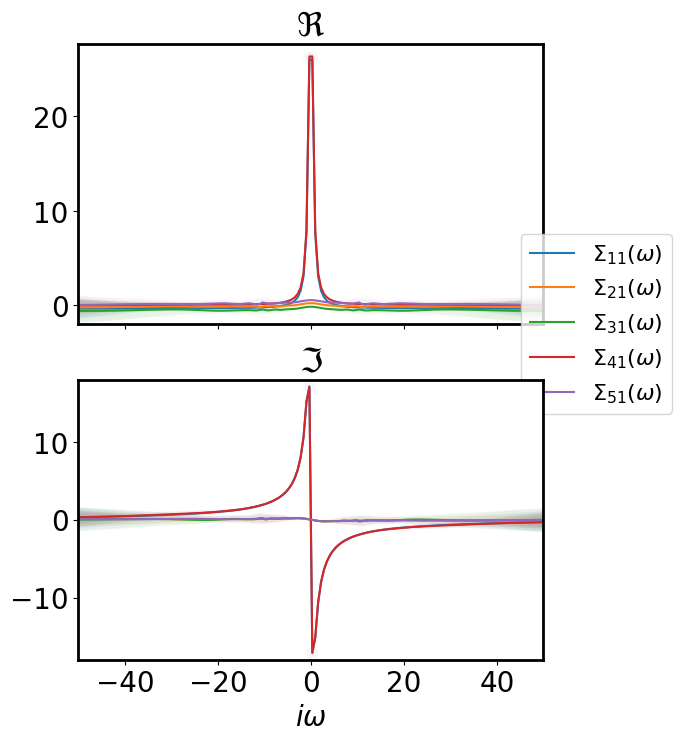

In [43]:
fig, axs = plt.subplots(2, 1, figsize=(6,8), sharex=True, sharey=False)

for ineq in range(0, num_ineq):
    for i in range(0, S_iw_m_a_src[ineq].shape[1]):
        label = r"$\Sigma_{" + str(i+1) + str(ineq+1) + "}(\omega)$"
        axs[0].plot(iw_src, S_iw_m_a_src[ineq][:,i].real, label=label)
        axs[0].scatter(iw_src, S_iw_m_a_src[ineq][:,i].real, 
    s=(100*S_iw_err_m_a_src[ineq][:,i])**2, alpha=0.02)
        axs[1].plot(iw_src, S_iw_m_a_src[ineq][:,i].imag, label=label)
        axs[1].scatter(iw_src, S_iw_m_a_src[ineq][:,i].imag, 
    s=(100*S_iw_err_m_a_src[ineq][:,i])**2, alpha=0.02)
     
axs[0].set_title("$\Re$")
axs[1].set_title("$\Im$")
axs[0].legend(ncol=1, fontsize=16, loc="center right", bbox_to_anchor=(1.3,0.0))
axs[0].set_xlim(-nKeep,nKeep)
axs[1].set_ylim(-18.0,18.0)
axs[1].set_xlabel(r"$i\omega$")

plotname = prefix + "S_iw_m" + postfix
plt.savefig(plotname, dpi=300, facecolor="white")
plt.show()

In [44]:
S_iw_m_a = {}
S_iw_m_a_err = {}

idx_roll = 0
for ineq in range(0, num_ineq):
    for i in range(0, S_iw_m_a_src[ineq].shape[1]):
        iw, S_iw_m_a[idx_roll] = cut_matsubara(iw_src, S_iw_m_a_src[ineq][:,i], nKeep, nStep)
        iw, S_iw_m_a_err[idx_roll] = cut_matsubara(iw_src, S_iw_err_m_a_src[ineq][:,i], nKeep, nStep)
        idx_roll += 1
#        S_iw_m_a_err[ineq+i] = np.ones_like(iw, dtype=np.float64) * aerr_s
        
if (w_grid_type == 'lin'):
    w = np.linspace(-w_max, w_max, num=n_w)
elif (w_grid_type == 'tan'):
    w = np.tan(np.linspace(-np.pi/2.5,np.pi/2.5,num=n_w,endpoint=True))*w_max/np.tan(np.pi/2.5)

w_lin = np.linspace(-w_max, w_max, num=n_w)
model = np.ones_like(w)
model /= np.trapz(model, w)

idx_roll = 0
S_iw = np.zeros(iw.shape[0]) + 0.j
for ineq in range(0, num_ineq):
    for i in range(0, S_iw_m_a_src[ineq].shape[1]):
        S_iw += S_iw_m_a[idx_roll]
        idx_roll += 1
        
count_bands = idx_roll

In [ ]:
cont_problem = {}
sol = {}

idx_roll = 0
for ineq in range(0, num_ineq):
    for i in range(0, S_iw_m_a_src[ineq].shape[1]):
        cont_problem[idx_roll] = cont.AnalyticContinuationProblem(im_axis = iw, re_axis = w, 
im_data = S_iw_m_a[idx_roll], kernel_mode = 'freq_fermionic', beta=beta)
        sol[idx_roll], _ = cont_problem[idx_roll].solve(method = 'maxent_svd', 
optimizer = 'newton', alpha_determination = alpha_det_method, model=model, stdev=S_iw_m_a_err[idx_roll],
alpha_start=1e12, alpha_end=1e-4, alpha_div = 10,
interactive=False, preblur=use_preblur, blur_width = bw)
        idx_roll += 1

1001 data points on real axis
100 data points on imaginary axis
39 significant singular values
Precomputation of coefficient matrices...
log10(alpha) = 12.00,	chi2 = 6.399e+06+0.000e+00j,   S = -5.473e-15+0.000e+00j,   nfev = 1,   norm = 1.000+0.000j
log10(alpha) = 11.00,	chi2 = 6.399e+06+0.000e+00j,   S = -5.471e-13+0.000e+00j,   nfev = 1,   norm = 1.000+0.000j
log10(alpha) = 10.00,	chi2 = 6.399e+06+0.000e+00j,   S = -5.471e-11+0.000e+00j,   nfev = 2,   norm = 1.000+0.000j
log10(alpha) = 9.00,	chi2 = 6.399e+06+0.000e+00j,   S = -5.472e-09+0.000e+00j,   nfev = 8,   norm = 1.000+0.000j
log10(alpha) = 8.00,	chi2 = 6.398e+06+0.000e+00j,   S = -5.479e-07+0.000e+00j,   nfev = 12,   norm = 1.001+0.000j
log10(alpha) = 7.00,	chi2 = 6.396e+06+0.000e+00j,   S = -5.557e-05+0.000e+00j,   nfev = 15,   norm = 1.007+0.000j
log10(alpha) = 6.00,	chi2 = 6.374e+06+0.000e+00j,   S = -6.418e-03+0.000e+00j,   nfev = 18,   norm = 1.072+0.000j
log10(alpha) = 5.00,	chi2 = 5.537e+06+0.000e+00j,   S = -2.883e+00

In [ ]:
S_w_m_a = {}

idx_roll = 0
for ineq in range(0, num_ineq):
    for i in range(0, S_iw_m_a_src[ineq].shape[1]):
        S_w_m_a[idx_roll] = cont.GreensFunction(spectrum=sol[idx_roll].A_opt, 
    wgrid=w, kind="fermionic",).kkt() +  hartree[ineq][i]
        alpha_s = sol[idx_roll].__dict__["alpha"]
        chi2_s = sol[idx_roll].chi2
        idx_roll += 1

In [ ]:
S_w = np.zeros(w.shape[0]) + 0.j
S_w_m = np.zeros((w.shape[0], count_bands)) + 0.j
dc_m = np.zeros(count_bands)
S_iw_bktr = np.zeros(iw.shape[0]) + 0.j
idx_roll = 0
for ineq in range(0, num_ineq):
    for i in range(0, S_iw_m_a_src[ineq].shape[1]):
        S_w += S_w_m_a[idx_roll]
        S_iw_bktr += sol[idx_roll].backtransform
        S_w_m[:,idx_roll] = S_w_m_a[idx_roll]
        dc_m[idx_roll] = dc_a[ineq][i]
        idx_roll += 1
        
count_bands = idx_roll

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16,8), sharex=False, sharey=False)

idx_roll = 0
for ineq in range(0, num_ineq):
    for i in range(0, S_iw_m_a_src[ineq].shape[1]):
        label = r"$\Sigma_{" + str(i+1) + str(ineq+1) + "}(\omega)$"
        axs[0][0].plot(w, S_w_m[:,idx_roll].real, label=label)
        axs[1][0].plot(w, S_w_m[:,idx_roll].imag, label=label)
        idx_roll += 1

axs[0][1].plot(iw, S_iw_bktr.real, color="tab:blue", linestyle="solid", label=r"$\Re[\Sigma]$ - back")
axs[0][1].scatter(iw, S_iw.real, color="tab:purple", marker="o", label=r"$\Re[\Sigma]$ - pre")
axs[0][1].plot(iw, S_iw_bktr.imag, color="tab:orange", linestyle="solid", label=r"$\Im[\Sigma]$ - back")
axs[0][1].scatter(iw, S_iw.imag, color="tab:red", marker="o", label=r"$\Im[\Sigma]$ - pre")
        
axs[1][1].plot(iw,(S_iw_bktr - S_iw).real, color="tab:blue")
axs[1][1].plot(iw,(S_iw_bktr - S_iw).imag, color="tab:orange")


axs[0][0].legend(ncol=3, fontsize=16)
axs[0][1].legend(ncol=2, fontsize=16)
axs[0][0].set_xlim(-w_max,w_max)
axs[1][0].set_xlim(-w_max,w_max)
axs[0][1].set_xlim(0,50)
axs[1][1].set_xlim(0,50)
#axs[1][0].set_xlim(-5,5)
#axs[0][0].set_xlim(-5,5)
axs[1][0].set_xlabel(r"$\omega$")
axs[1][1].set_xlabel(r"$i\omega$")

plotname = prefix + "S_w_m_cont_check" + postfix
plt.savefig(plotname, dpi=300, facecolor="white")
plt.show()

In [ ]:
path = np.asarray([[0.375, 0.750, 0.375],
                   [0.000, 0.500, 0.000],
                   [0.000, 0.500, 0.500],
                   [0.250, 0.750, 0.500],
                   [0.500, 0.500, 0.500],
                   [0.000, 0.000, 0.000]])
labels = ["K", "X", "G", "W", "L", "G"]
fig, axs, bands, k_dft = get_Bandstructure(H, path, labels, 50, -15, 10, Efermi_dft)
axs.axhline(0, color="black", linewidth=1)

plotname = prefix + "_dft_bands_" + postfix
plt.savefig(plotname, dpi=300, facecolor="white")
plt.show()

In [ ]:
n = count_bands
mu = np.mean(DMFT_results.mu)

k, Hk, lines = get_Hk(H, path, labels, 50)
denominator = np.zeros((k.shape[0],w.shape[0],n,n)) + 0.j
A_kw_mn = np.zeros_like(denominator)
A_kw = np.diagonal(A_kw_mn, axis1=2, axis2=3)

In [ ]:
id_mat = np.eye(n)
w_plot = w[None,:,None,None]*id_mat[None,None,:,:]
Hk_plot = Hk[:,None,:,:]
S_w_m_plot = S_w_m[None,:,None,:]*id_mat[None,None,:,:]
   
#denominator = w_plot - Hk_plot + Efermi_dft*id_mat + 1.j*0.1*id_mat ## Noninteracting
denominator = w_plot - Hk_plot + (mu)*id_mat - S_w_m_plot - dc_m*id_mat + 1.j*0.1*id_mat


A_kw_mn = -(1/np.pi*np.linalg.inv(denominator)).imag
A_kw = np.diagonal(A_kw_mn, axis1=2, axis2=3)

In [ ]:
print(k.shape, w.shape, A_kw.shape)
K, W = np.meshgrid(k, w, indexing="ij")  
fig, axs = plt.subplots(1, 1, figsize=(10, 6))
saturate = 0.75
vmax = np.max(np.sum(A_kw, axis=2)*saturate)
CS = axs.pcolormesh(K, W, np.sum(A_kw, axis=2), cmap="magma", vmin=0, vmax=vmax) 
# axs[0].imshow(np.sum(A_kw, axis=2).real, cmap="magma") 
axs.axhline(0, color="white", linewidth=1)
for band in range(0, len(bands[0,:])):
    axs.plot(k_dft, bands[:,band]-Efermi_dft, zorder=10, color="white", linewidth=1)
axs.set_ylim(-12, 10)
axs.set_xticks(lines)
axs.set_xticklabels(labels)
axs.set_ylabel("E (eV)")
axs.xaxis.grid(color="white", linewidth=1)
cbar = fig.colorbar(CS, pad = 1e-2, ticks=np.arange(0, vmax/saturate, 2))
cbar.set_label(r"$A(\vec{k},\omega)$", rotation=270, labelpad=24)


plotname = prefix + "_dmft_A_kw_" + postfix
plt.savefig(plotname, dpi=300, facecolor="white")
plt.show()